In [3]:
%%capture
%pip install torchvision
%pip install torchsummary
%pip install torchviz
%pip install hiddenlayer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning

Mounted at /content/drive
/content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning


In [5]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torch.autograd import Variable
from torchvision import datasets, transforms

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun 29 16:51:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Dataset Loading

In [7]:
#model params
params = {
    'epochs':100,
    'batch_size':32,
    'mul': 30,
    'num_classes':10,
    'channels':3,
    'img_dim':32,
    'device':torch.device('cuda') if torch.cuda.is_available() else 'cpu',
    'lr':0.00002,    #learning rate for generator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10  ,  #lambdaB for cycle loss
}


In [8]:
# Function to load and preprocess datasets
def load_dataset(dataset_cls, split, root, download, normalize=False, subset_size=None, batch_size=params['batch_size']):
    """
      Load and preprocess a dataset.
      :param dataset_cls: Dataset class (e.g., datasets.MNIST, datasets.SVHN)
      :param split: Data split ('train' or 'test')
      :param root: Root directory for dataset storage/download
      :param download: Flag to download the dataset if not present
      :param normalize: Flag to normalize the dataset
      :param subset_size: Size of the subset to use (if specified)
      :param batch_size: Batch size for DataLoader
      :return: DataLoader object
    """
    if dataset_cls == datasets.MNIST:
        dataset = dataset_cls(root=root, train=(split=='train'), download=download, transform=transforms.ToTensor())
    else:
        dataset = dataset_cls(root=root, split=split, download=download, transform=transforms.ToTensor())

    if normalize:
        # mean, std = compute_mean_and_std(dataset)

        if dataset_cls == datasets.MNIST:

            print(f"Dataset is MNIST: {dataset_cls}")
            transform = transforms.Compose([
                transforms.Resize(( params['img_dim'],params['img_dim']) ),
                transforms.Grayscale(params['channels']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
            ])\

        else:
            print(f"Dataset is SVHN: {dataset_cls}")
            transform = transforms.Compose([
                transforms.Resize(( params['img_dim'],params['img_dim'] )),
                transforms.Grayscale(params['channels']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
            ])

        # Apply the computed normalization
        dataset.transform = transform

    if subset_size:
        indices = np.random.choice(len(dataset), subset_size, replace=False)
        print(dataset.transform)
        dataset = Subset(dataset, indices)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True if split == 'train' else False, num_workers=1)
    return loader

# Load MNIST datasets
mnist_trainloader = load_dataset(datasets.MNIST, 'train', './data/', True, normalize=True,subset_size=params['batch_size']*params['mul'] )
mnist_testloader = load_dataset(datasets.MNIST, 'test', './data/', True, normalize=True)

# Load SVHN datasets
svhn_trainloader = load_dataset(datasets.SVHN, 'train', './data/', True, normalize=True,subset_size=params['batch_size']*params['mul'])
svhn_testloader = load_dataset(datasets.SVHN, 'test', './data/', True, normalize=True)

# Verify the sizes of the datasets
print(f'MNIST train subset size: {len(mnist_trainloader.dataset)}')
print(f'SVHN train subset size: {len(svhn_trainloader.dataset)}')

Dataset is MNIST: <class 'torchvision.datasets.mnist.MNIST'>
Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Dataset is MNIST: <class 'torchvision.datasets.mnist.MNIST'>
Using downloaded and verified file: ./data/train_32x32.mat
Dataset is SVHN: <class 'torchvision.datasets.svhn.SVHN'>
Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Using downloaded and verified file: ./data/test_32x32.mat
Dataset is SVHN: <class 'torchvision.datasets.svhn.SVHN'>
MNIST train subset size: 960
SVHN train subset size: 960


In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations (same as during training)
transform = transforms.Compose([
    transforms.Grayscale(3),  # Ensure images are single-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize([0.5]*params['channels'], [0.5]*params['channels'])  # Assuming normalization parameters used during training
])

# Define the path to the transformed images
transformed_images_path = 'transformed_mnist_train'

# Create the dataset
transformed_dataset = datasets.ImageFolder(root=transformed_images_path, transform=transform)

# Create the DataLoader
transformed_dataloader = DataLoader(transformed_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=8)

### Baseline Model

Our baseline model here is a simple CNN.

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Use a dummy input to determine the size of the flattened features
        dummy_input = torch.randn(1, 3, 32, 32)  # Change the input size if necessary
        dummy_output = self.feature_extractor(dummy_input)
        flattened_size = dummy_output.view(-1).size(0)

        # Now use the calculated flattened size for the classifier
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        return output

class DomainDiscriminator(nn.Module):
    def __init__(self, feature_size):
        super(DomainDiscriminator, self).__init__()
        self.domain_classifier = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, 2)  # Two classes: source and target
        )

    def forward(self, x):
        output = self.domain_classifier(x)
        return output

# Initialize the model and print the flattened feature size
model = SimpleCNN()
print(model)


SimpleCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10

In [11]:
feature_extractor = SimpleCNN().to(params['device'])
flattened_size = feature_extractor.classifier[0].in_features  # Get the input feature size of the first Linear layer
domain_discriminator = DomainDiscriminator(flattened_size).to(params['device'])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(feature_extractor.parameters()) + list(domain_discriminator.parameters()), lr=0.00001)


#### Baseline model Training

In [12]:
def train(model, domain_model, source_loader, target_loader, criterion, optimizer, num_epochs=20):
    """
      Train the models.
      :param model: Main model
      :param domain_model: Domain discriminator model
      :param source_loader: DataLoader for source data
      :param target_loader: DataLoader for target data
      :param criterion: Loss function
      :param optimizer: Optimizer for model parameters
      :param num_epochs: Number of training epochs
      :return: None
    """
    model.train()
    domain_model.train()

    for epoch in range(num_epochs):
        for (source_data, source_labels), (target_data, _) in zip(source_loader, target_loader):
            source_data, source_labels = source_data.to(params['device']), source_labels.to(params['device'])
            target_data = target_data.to(params['device'])

            # Train feature extractor and classifier on source data
            optimizer.zero_grad()
            source_features = model.feature_extractor(source_data)
            source_output = model.classifier(source_features.view(source_features.size(0), -1))
            source_loss = criterion(source_output, source_labels)
            source_loss.backward()
            optimizer.step()

            # Train domain discriminator on source and target data
            optimizer.zero_grad()
            domain_labels = torch.cat((torch.zeros(source_data.size(0)), torch.ones(target_data.size(0)))).long().to(params['device'])
            combined_data = torch.cat((source_data, target_data))
            combined_features = model.feature_extractor(combined_data)
            domain_output = domain_model(combined_features.view(combined_features.size(0), -1))
            domain_loss = criterion(domain_output, domain_labels)
            domain_loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Source Loss: {source_loss.item():.4f}, Domain Loss: {domain_loss.item():.4f}')

# Train the model
train(feature_extractor, domain_discriminator, mnist_trainloader, svhn_trainloader, criterion, optimizer)


Epoch [1/20], Source Loss: 2.1032, Domain Loss: 0.2101
Epoch [2/20], Source Loss: 1.9354, Domain Loss: 0.0758
Epoch [3/20], Source Loss: 1.6639, Domain Loss: 0.0343
Epoch [4/20], Source Loss: 1.5879, Domain Loss: 0.0228
Epoch [5/20], Source Loss: 1.4496, Domain Loss: 0.0138
Epoch [6/20], Source Loss: 1.2406, Domain Loss: 0.0096
Epoch [7/20], Source Loss: 1.0843, Domain Loss: 0.0094
Epoch [8/20], Source Loss: 0.9234, Domain Loss: 0.0047
Epoch [9/20], Source Loss: 0.9189, Domain Loss: 0.0051
Epoch [10/20], Source Loss: 0.7294, Domain Loss: 0.0034
Epoch [11/20], Source Loss: 0.8244, Domain Loss: 0.0039
Epoch [12/20], Source Loss: 0.6742, Domain Loss: 0.0029
Epoch [13/20], Source Loss: 0.6675, Domain Loss: 0.0029
Epoch [14/20], Source Loss: 0.5175, Domain Loss: 0.0020
Epoch [15/20], Source Loss: 0.5915, Domain Loss: 0.0026
Epoch [16/20], Source Loss: 0.3279, Domain Loss: 0.0018
Epoch [17/20], Source Loss: 0.3644, Domain Loss: 0.0015
Epoch [18/20], Source Loss: 0.3163, Domain Loss: 0.0011
E

In [13]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(params['device']), labels.to(params['device'])
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

source_accuracy = evaluate(feature_extractor, mnist_testloader, params['device'])
target_accuracy = evaluate(feature_extractor, svhn_testloader, params['device'])
print(f'Source (MNIST) Accuracy: {source_accuracy:.2f}%')
print(f'Target (SVHN) Accuracy: {target_accuracy:.2f}%')


Source (MNIST) Accuracy: 94.15%
Target (SVHN) Accuracy: 21.24%


### VGG16 architexture

In [14]:
# Define the VGG-16 architecture without pretrained weights
class VGG16Custom(nn.Module):
    def __init__(self, num_classes=params['num_classes']):
        super(VGG16Custom, self).__init__()
        # Load the VGG-16 model
        self.features = models.vgg16(weights=None).features
        # Modify the first convolutional layer to accept 1-channel input
        self.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        # Add a custom classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            # nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 512)
        x = self.classifier(x)
        return x

In [15]:
def CORAL(source, target):
    d = source.data.shape[1]

    # source covariance
    xm = torch.mean(source, 0, keepdim=True) - source
    xc = xm.t() @ xm

    # target covariance
    xmt = torch.mean(target, 0, keepdim=True) - target
    xct = xmt.t() @ xmt

    # frobenius norm between source and target
    loss = torch.mean(torch.mul((xc - xct), (xc - xct)))
    loss = loss/(4*d*d)

    return loss


In [16]:
class DeepCORAL(nn.Module):
    def __init__(self, num_classes=params['num_classes']):
        super(DeepCORAL, self).__init__()
        self.sharedNet = VGG16Custom()
        self.fc = nn.Linear(4096, num_classes)

        # initialize according to CORAL paper experiment
        self.fc.weight.data.normal_(0, 0.005)

    def forward(self, source, target):
        source = self.sharedNet(source)
        source = self.fc(source)

        target = self.sharedNet(target)
        target = self.fc(target)
        return source, target

In [17]:
# Function to load pretrained weights into the DeepCORAL model and freeze feature layers
def load_pretrained(model, pretrained_path):
    pretrained_vgg = torch.load(pretrained_path)
    model_dict = model.state_dict()

    # filter out unmatch dict and delete last fc bias, weight
    pretrained_dict = {k: v for k, v in pretrained_vgg.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    # # Freeze the feature layers of the VGG16 model
    # for param in model.features.parameters():
    #     param.requires_grad = False

    return model
# Example of loading pretrained weights into DeepCORAL
pretrained_path = 'model_checkpoints/3channeled_vgg16_mnist.pth'  # Specify your pre-trained VGG-16 model path
deepcoral = DeepCORAL(num_classes=10)
deepcoral.sharedNet = load_pretrained(deepcoral.sharedNet, pretrained_path)
print(deepcoral)
print("\n\n")



# Move model to device
deepcoral.to(params['device'])

optimizer = optim.Adam(deepcoral.parameters(), lr=0.00002)

DeepCORAL(
  (sharedNet): VGG16Custom(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

Train Epoch:  1 [30/30]	Lambda: 0.5000, Class: 0.819545, CORAL: 0.506657, Total_Loss: 1.072874

Test Epoch: 1 Average loss: 2.2225, Accuracy: 7661/26032 (29.43%)

Test Epoch: 1, Target Domain Accuracy: 29.43%
New best model accuracy: 29.43%
Train Epoch:  2 [30/30]	Lambda: 0.5000, Class: 0.501689, CORAL: 0.388398, Total_Loss: 0.695888

Test Epoch: 2 Average loss: 2.2093, Accuracy: 8094/26032 (31.09%)

Test Epoch: 2, Target Domain Accuracy: 31.09%
New best model accuracy: 31.09%
Train Epoch:  3 [30/30]	Lambda: 0.5000, Class: 0.390718, CORAL: 0.369871, Total_Loss: 0.575654

Test Epoch: 3 Average loss: 2.1915, Accuracy: 8252/26032 (31.70%)

Test Epoch: 3, Target Domain Accuracy: 31.70%
New best model accuracy: 31.70%
Train Epoch:  4 [30/30]	Lambda: 0.5000, Class: 0.385900, CORAL: 0.362847, Total_Loss: 0.567323

Test Epoch: 4 Average loss: 2.1843, Accuracy: 8278/26032 (31.80%)

Test Epoch: 4, Target Domain Accuracy: 31.80%
New best model accuracy: 31.80%
Train Epoch:  5 [30/30]	Lambda: 0.50

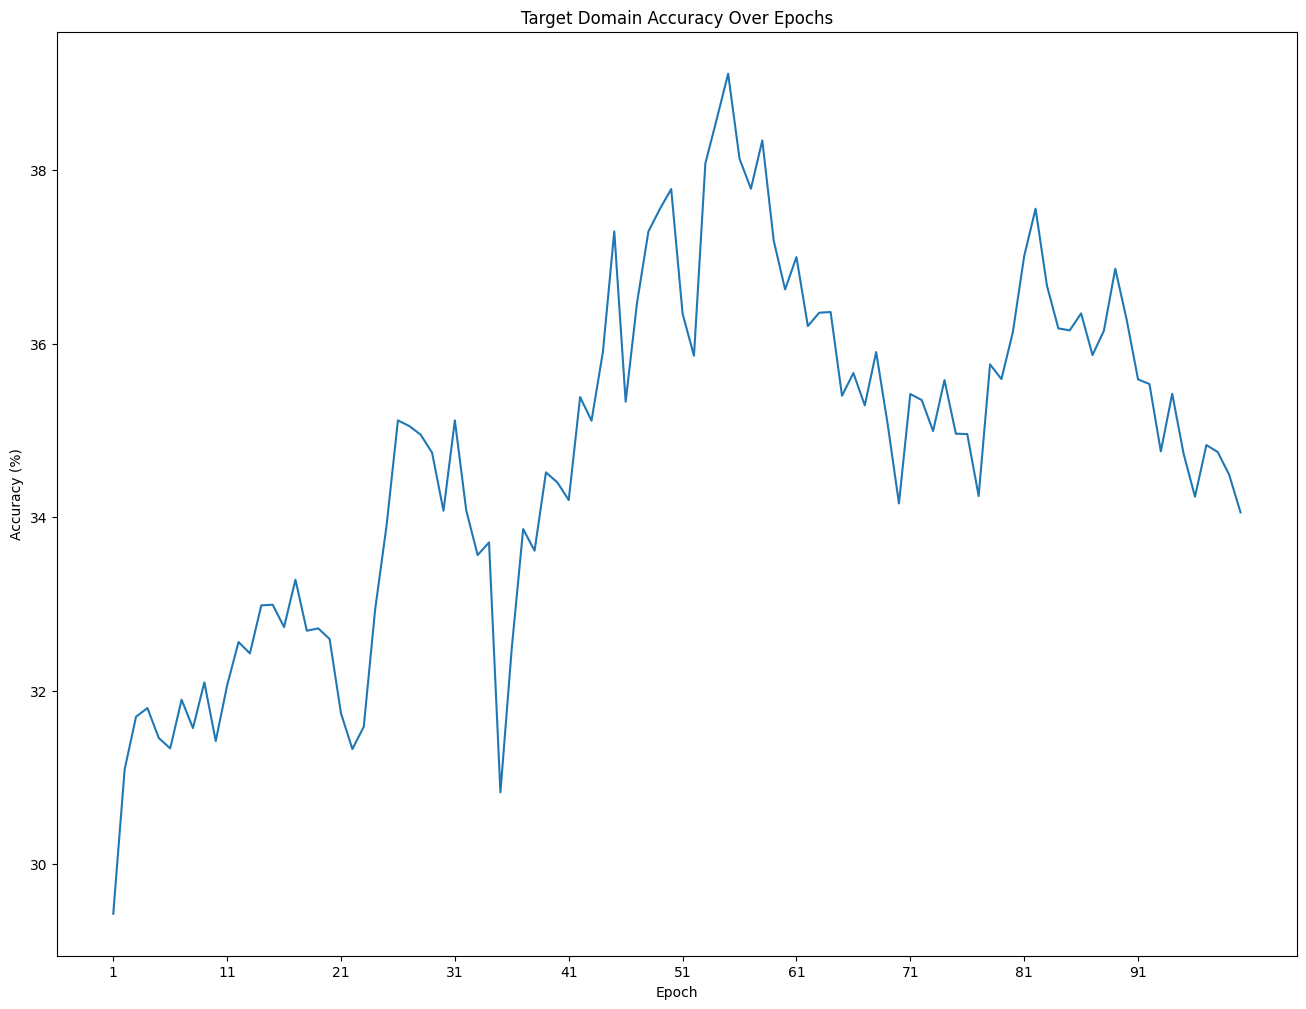

In [18]:
source_trainloader = mnist_trainloader
target_trainloader = svhn_trainloader

# Training function
def train(model, source_loader, target_loader, optimizer, epoch, _lambda, params):
    model.train()
    result = []
    source, target = list(iter(source_loader)), list(iter(target_loader))
    train_steps = min(len(source), len(target))

    for batch_idx in range(train_steps):
        source_data, source_label = source[batch_idx]
        target_data, _ = target[batch_idx]

        source_data, source_label = Variable(source_data.to(params['device'])), Variable(source_label.to(params['device']))
        target_data = Variable(target_data.to(params['device']))

        optimizer.zero_grad()
        out1, out2 = model(source_data, target_data)

        classification_loss = F.cross_entropy(out1, source_label)
        coral_loss = CORAL(out1, out2)

        total_loss = _lambda * coral_loss + classification_loss
        total_loss.backward()
        optimizer.step()

        result.append({
            'epoch': epoch,
            'step': batch_idx + 1,
            'total_steps': train_steps,
            'lambda': _lambda,
            'coral_loss': coral_loss.item(),
            'classification_loss': classification_loss.item(),
            'total_loss': total_loss.item()
        })

    print('Train Epoch: {:2d} [{:2d}/{:2d}]\t'
          'Lambda: {:.4f}, Class: {:.6f}, CORAL: {:.6f}, Total_Loss: {:.6f}'.format(
        epoch, batch_idx + 1, train_steps, _lambda,
        classification_loss.item(), coral_loss.item(), total_loss.item()))

    return result

def test(model, dataset_loader, epoch, params):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataset_loader:

            data, target = data.to(params['device']), target.to(params['device'])

            out, _ = model(data, data)
            test_loss += F.cross_entropy(out, target, reduction='sum').item()

            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dataset_loader.dataset)
    accuracy = 100. * correct / len(dataset_loader.dataset)

    print('\nTest Epoch: {} Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(dataset_loader.dataset), accuracy))

    return {
        'epoch': epoch,
        'average_loss': test_loss,
        'correct': correct,
        'total': len(dataset_loader.dataset),
        'accuracy': accuracy
    }

# Main training and testing loop
best_accuracy = 0.0
accuracies = []  # List to store accuracy for each epoch
for epoch in range(1, params['epochs'] + 1):
    train_results = train(deepcoral, source_trainloader, target_trainloader, optimizer, epoch, _lambda=0.5, params=params)
    test_results = test(deepcoral, svhn_testloader, epoch, params=params)
    accuracies.append(test_results['accuracy'])
    print(f"Test Epoch: {epoch}, Target Domain Accuracy: {test_results['accuracy']:.2f}%")

    # Save the model if the accuracy improves
    if test_results['accuracy'] > best_accuracy:
        best_accuracy = test_results['accuracy']
        # torch.save(deepcoral.state_dict(), 'model_checkpoints/best_deepCORAL.pth')
        print(f"New best model accuracy: {best_accuracy:.2f}%")

epochs = np.arange(1, params['epochs'] + 1) # x-axis
# Plotting the accuracy
plt.figure(figsize=(16, 12))
plt.plot(epochs, accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Target Domain Accuracy Over Epochs')

# Adjusting x-axis ticks to avoid crowding
plt.xticks(range(1, len(accuracies) + 1, max(1, len(accuracies) // 10)))

plt.grid(False)
plt.show()

### UDA using SVHN pre-trained VGG16

In [19]:
# best_accuracy = 0.0
# Example of loading pretrained weights into DeepCORAL
pretrained_path = 'model_checkpoints/3channeled_vgg16_svhn.pth'  # Specify your pre-trained VGG-16 model path
deepcoral = DeepCORAL(num_classes=10)
deepcoral.sharedNet = load_pretrained(deepcoral.sharedNet, pretrained_path)

# Move model to device
deepcoral.to(params['device'])

optimizer = optim.Adam(deepcoral.parameters(), lr=0.00002)


source_trainloader = svhn_trainloader
target_trainloader = mnist_trainloader


# Main training and testing loop
best_accuracy = 0.0
accuracies = []  # List to store accuracy for each epoch
for epoch in range(1, params['epochs'] + 1):
    train_results = train(deepcoral, source_trainloader, target_trainloader, optimizer, epoch, _lambda=0.5, params=params)
    test_results = test(deepcoral, mnist_testloader, epoch, params=params)
    accuracies.append(test_results['accuracy'])
    print(f"Test Epoch: {epoch}, Target Domain Accuracy: {test_results['accuracy']:.2f}%")

    # Show if the accuracy improves
    if test_results['accuracy'] > best_accuracy:
        best_accuracy = test_results['accuracy']
        print(f"New best model saved with accuracy: {best_accuracy:.2f}%")



Train Epoch:  1 [30/30]	Lambda: 0.5000, Class: 1.735706, CORAL: 0.022203, Total_Loss: 1.746808

Test Epoch: 1 Average loss: 1.8831, Accuracy: 5038/10000 (50.38%)

Test Epoch: 1, Target Domain Accuracy: 50.38%
New best model saved with accuracy: 50.38%
Train Epoch:  2 [30/30]	Lambda: 0.5000, Class: 0.739808, CORAL: 0.297941, Total_Loss: 0.888779

Test Epoch: 2 Average loss: 1.3463, Accuracy: 6528/10000 (65.28%)

Test Epoch: 2, Target Domain Accuracy: 65.28%
New best model saved with accuracy: 65.28%
Train Epoch:  3 [30/30]	Lambda: 0.5000, Class: 0.631854, CORAL: 0.272058, Total_Loss: 0.767883

Test Epoch: 3 Average loss: 1.3083, Accuracy: 6434/10000 (64.34%)

Test Epoch: 3, Target Domain Accuracy: 64.34%
Train Epoch:  4 [30/30]	Lambda: 0.5000, Class: 0.623787, CORAL: 0.324167, Total_Loss: 0.785870

Test Epoch: 4 Average loss: 1.2721, Accuracy: 6440/10000 (64.40%)

Test Epoch: 4, Target Domain Accuracy: 64.40%
Train Epoch:  5 [30/30]	Lambda: 0.5000, Class: 0.545945, CORAL: 0.264110, Tota

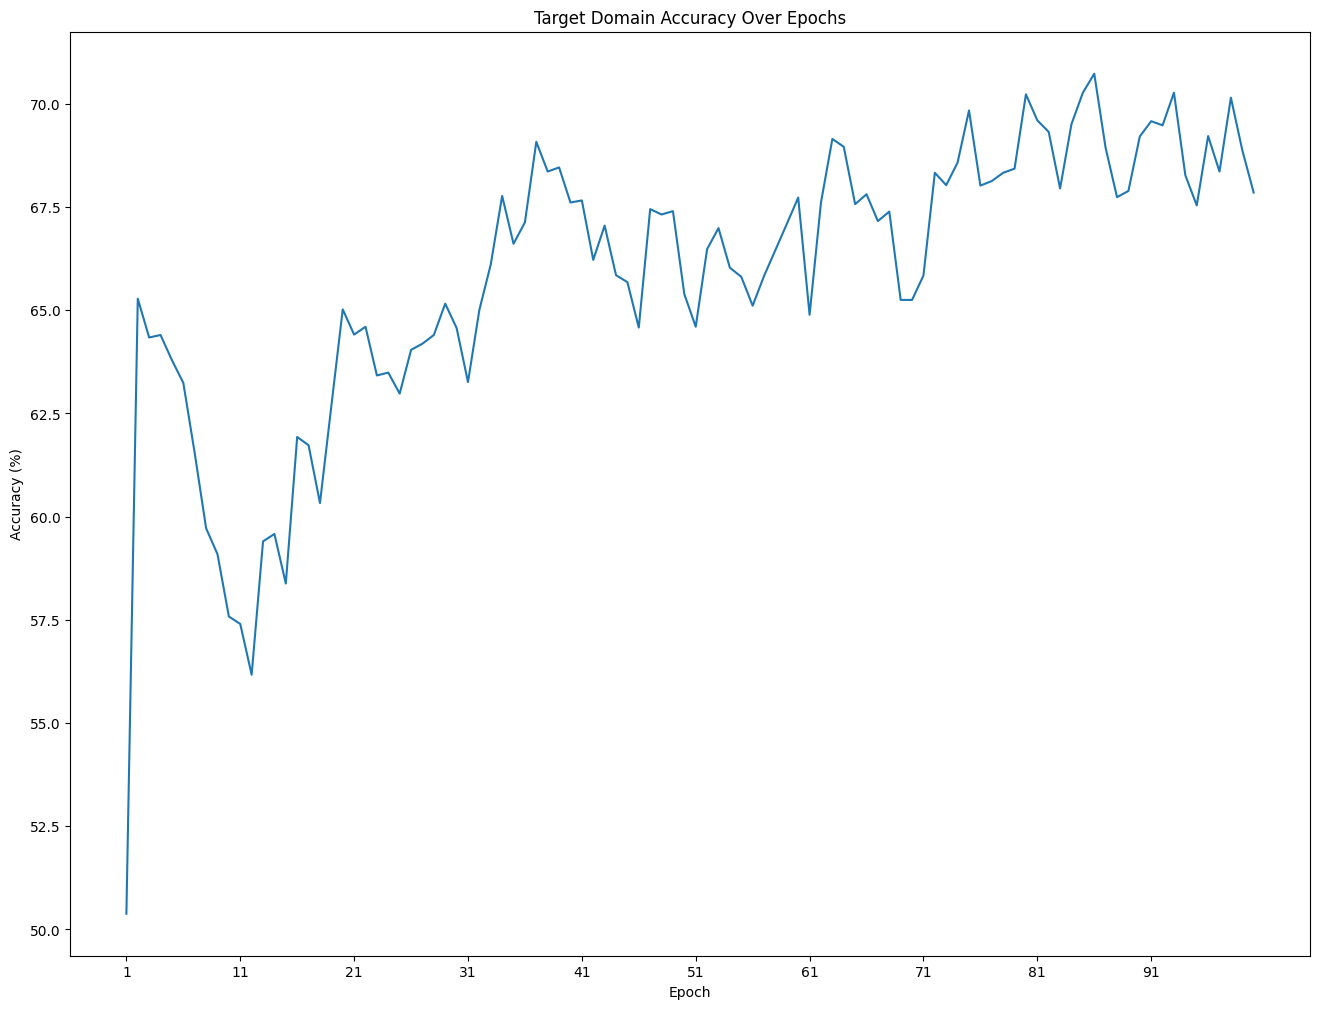

In [20]:
epochs = np.arange(1, params['epochs'] + 1)
# Plotting the accuracy
plt.figure(figsize=(16, 12))
plt.plot(epochs, accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Target Domain Accuracy Over Epochs')

# Adjusting x-axis ticks to avoid crowding
plt.xticks(range(1, len(accuracies) + 1, max(1, len(accuracies) // 10)))

plt.grid(False)
plt.show()